# Process API

create an account on sentinal-hub, create a new client and save the credentials

In [1]:
from sentinelhub import SHConfig

config = SHConfig()
#create an client and instance on sentinal-hub
config.sh_client_id = '1543b9e6-3abf-441b-9f19-0c8b70b925b2'
config.sh_client_secret = 'J2H.z_4ENpdQomb)Q1t*f-u?Zh<{)TH1Cd4JmQMv'
config.instance_id = "d6043a1f-543a-453e-acd6-8f90b6b74f56"
config.save()
if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

# Imports

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from datetime import datetime
from dateutil.relativedelta import relativedelta
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    Geometry,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image
from s2cloudless import CloudMaskRequest, S2PixelCloudDetector, get_s2_evalscript


Select Area

In [3]:
poly = [[7.090278,80.55444],[7.090278,80.55417],[7.090556,80.55222],[7.090278,80.55167],[7.09,80.55083],[7.091389,80.54806],[7.093056,80.55],[7.093333,80.55083],[7.094167,80.55306],[7.094167,80.55333],[7.093889,80.55417],[7.093611,80.555],[7.0925,80.55528],[7.091667,80.55528],[7.090833,80.555]]


In [4]:
#bounding box defining
def bbox_cord(poly):
    poly_arr = np.array(poly)
    df = pd.DataFrame(poly_arr, columns = ['long','lat'])
    Xmin = df['lat'].min()
    Ymin = df['long'].min()
    Xmax = df['lat'].max()
    Ymax = df['long'].max()
    bbox = [Xmin,Ymin,Xmax,Ymax]
    i = [1,0]
    output = poly_arr[:,i]
    output = output.tolist()
    return bbox,output
bbox_generated,poly = bbox_cord(poly)
bbox_generated

[80.54806, 7.09, 80.55528, 7.094167]

In [5]:
poly

[[80.55444, 7.090278],
 [80.55417, 7.090278],
 [80.55222, 7.090556],
 [80.55167, 7.090278],
 [80.55083, 7.09],
 [80.54806, 7.091389],
 [80.55, 7.093056],
 [80.55083, 7.093333],
 [80.55306, 7.094167],
 [80.55333, 7.094167],
 [80.55417, 7.093889],
 [80.555, 7.093611],
 [80.55528, 7.0925],
 [80.55528, 7.091667],
 [80.555, 7.090833]]

In [6]:
#define diementions for the request
final_bbox = BBox(bbox=bbox_generated, crs=CRS.WGS84)
geometry = Geometry(geometry={"type":"Polygon","coordinates":[poly]}, crs=CRS.WGS84)

In [7]:
#resolution and size of the output
resolution =10
box_size = bbox_to_dimensions(final_bbox, resolution= resolution)
print(f"Image shape at {resolution} m resolution: {box_size} pixels")

Image shape at 10 m resolution: (80, 46) pixels


In [8]:
#date range

current_date = datetime.today()
past_date = datetime.today() - relativedelta(months=6)
n_chunks = 6
tdelta = (current_date - past_date) / n_chunks
edges = [(past_date + i * tdelta).date().isoformat() for i in range(n_chunks+1)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

print("Monthly time windows:\n")
for slot in slots:
    print(slot)

Monthly time windows:

('2022-04-18', '2022-05-19')
('2022-05-19', '2022-06-18')
('2022-06-18', '2022-07-19')
('2022-07-19', '2022-08-18')
('2022-08-18', '2022-09-18')
('2022-09-18', '2022-10-18')


In [9]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04","B08","CLM"],
                
            }],
            output: {
                bands: 5,
                sampleType: "float32"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B02, sample.B03, sample.B04,sample.B08,sample.CLM];
    }
"""
#32 bit Tiff output wuth 4 bands
def request_all_bands(time_interval):
    
    return  SentinelHubRequest(
        data_folder="Data", #data store directory
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=time_interval,
                mosaicking_order=MosaickingOrder.LEAST_CC,
                #other_args={"dataFilter": {"maxCloudCoverage": 50}},
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=final_bbox,
        size=box_size,
        #geometry = geometry,
        config=config,
    )

In [10]:
# create a list of requests
list_of_requests = [request_all_bands(slot) for slot in slots]
list_of_requests = [request.get_data() for request in list_of_requests]
list_of_requests

[[array([[[0.6744, 0.6308, 0.6148, 0.6232, 1.    ],
          [0.7124, 0.6644, 0.6408, 0.6616, 1.    ],
          [0.7216, 0.6984, 0.6732, 0.6808, 1.    ],
          ...,
          [0.8664, 0.8032, 0.7696, 0.7792, 1.    ],
          [0.8928, 0.8376, 0.804 , 0.8152, 1.    ],
          [0.9184, 0.8592, 0.8416, 0.836 , 1.    ]],
  
         [[0.6764, 0.6388, 0.622 , 0.6312, 1.    ],
          [0.6988, 0.67  , 0.6476, 0.6524, 1.    ],
          [0.662 , 0.6608, 0.6696, 0.6352, 1.    ],
          ...,
          [0.8712, 0.8168, 0.7848, 0.8008, 1.    ],
          [0.8944, 0.8456, 0.8192, 0.8272, 1.    ],
          [0.9264, 0.8712, 0.84  , 0.8504, 1.    ]],
  
         [[0.6708, 0.6372, 0.628 , 0.6368, 1.    ],
          [0.6624, 0.6436, 0.63  , 0.62  , 1.    ],
          [0.598 , 0.5968, 0.6216, 0.5884, 1.    ],
          ...,
          [0.8464, 0.828 , 0.8008, 0.7944, 1.    ],
          [0.868 , 0.8424, 0.8288, 0.8056, 1.    ],
          [0.8856, 0.8664, 0.8544, 0.824 , 1.    ]],
  
       

In [11]:
list_of_requests[0][0][:, :,0].shape

(46, 80)

In [12]:
np.count_nonzero(list_of_requests[4][0][:, :,3] - list_of_requests[3][0][:, :,3])

3677

In [13]:
list_of_requests[4][0][:, :,0] - list_of_requests[3][0][:, :,0]

array([[0.0319    , 0.0272    , 0.0269    , ..., 0.0208    , 0.0126    ,
        0.0067    ],
       [0.0317    , 0.0239    , 0.0276    , ..., 0.0169    , 0.01      ,
        0.0087    ],
       [0.0318    , 0.0218    , 0.0227    , ..., 0.0142    , 0.0101    ,
        0.0118    ],
       ...,
       [0.1212    , 0.0632    , 0.0436    , ..., 0.016     , 0.0301    ,
        0.0048    ],
       [0.1143    , 0.0683    , 0.0579    , ..., 0.0086    , 0.0347    ,
        0.0019    ],
       [0.1147    , 0.08940001, 0.0766    , ..., 0.0167    , 0.0288    ,
        0.0065    ]], dtype=float32)

0 3680 ('2022-04-18', '2022-05-19') (46, 80, 3)
1 3680 ('2022-05-19', '2022-06-18') (46, 80, 3)
2 0 ('2022-06-18', '2022-07-19') (46, 80, 3)
3 0 ('2022-07-19', '2022-08-18') (46, 80, 3)
4 0 ('2022-08-18', '2022-09-18') (46, 80, 3)
5 2630 ('2022-09-18', '2022-10-18') (46, 80, 3)
0 4


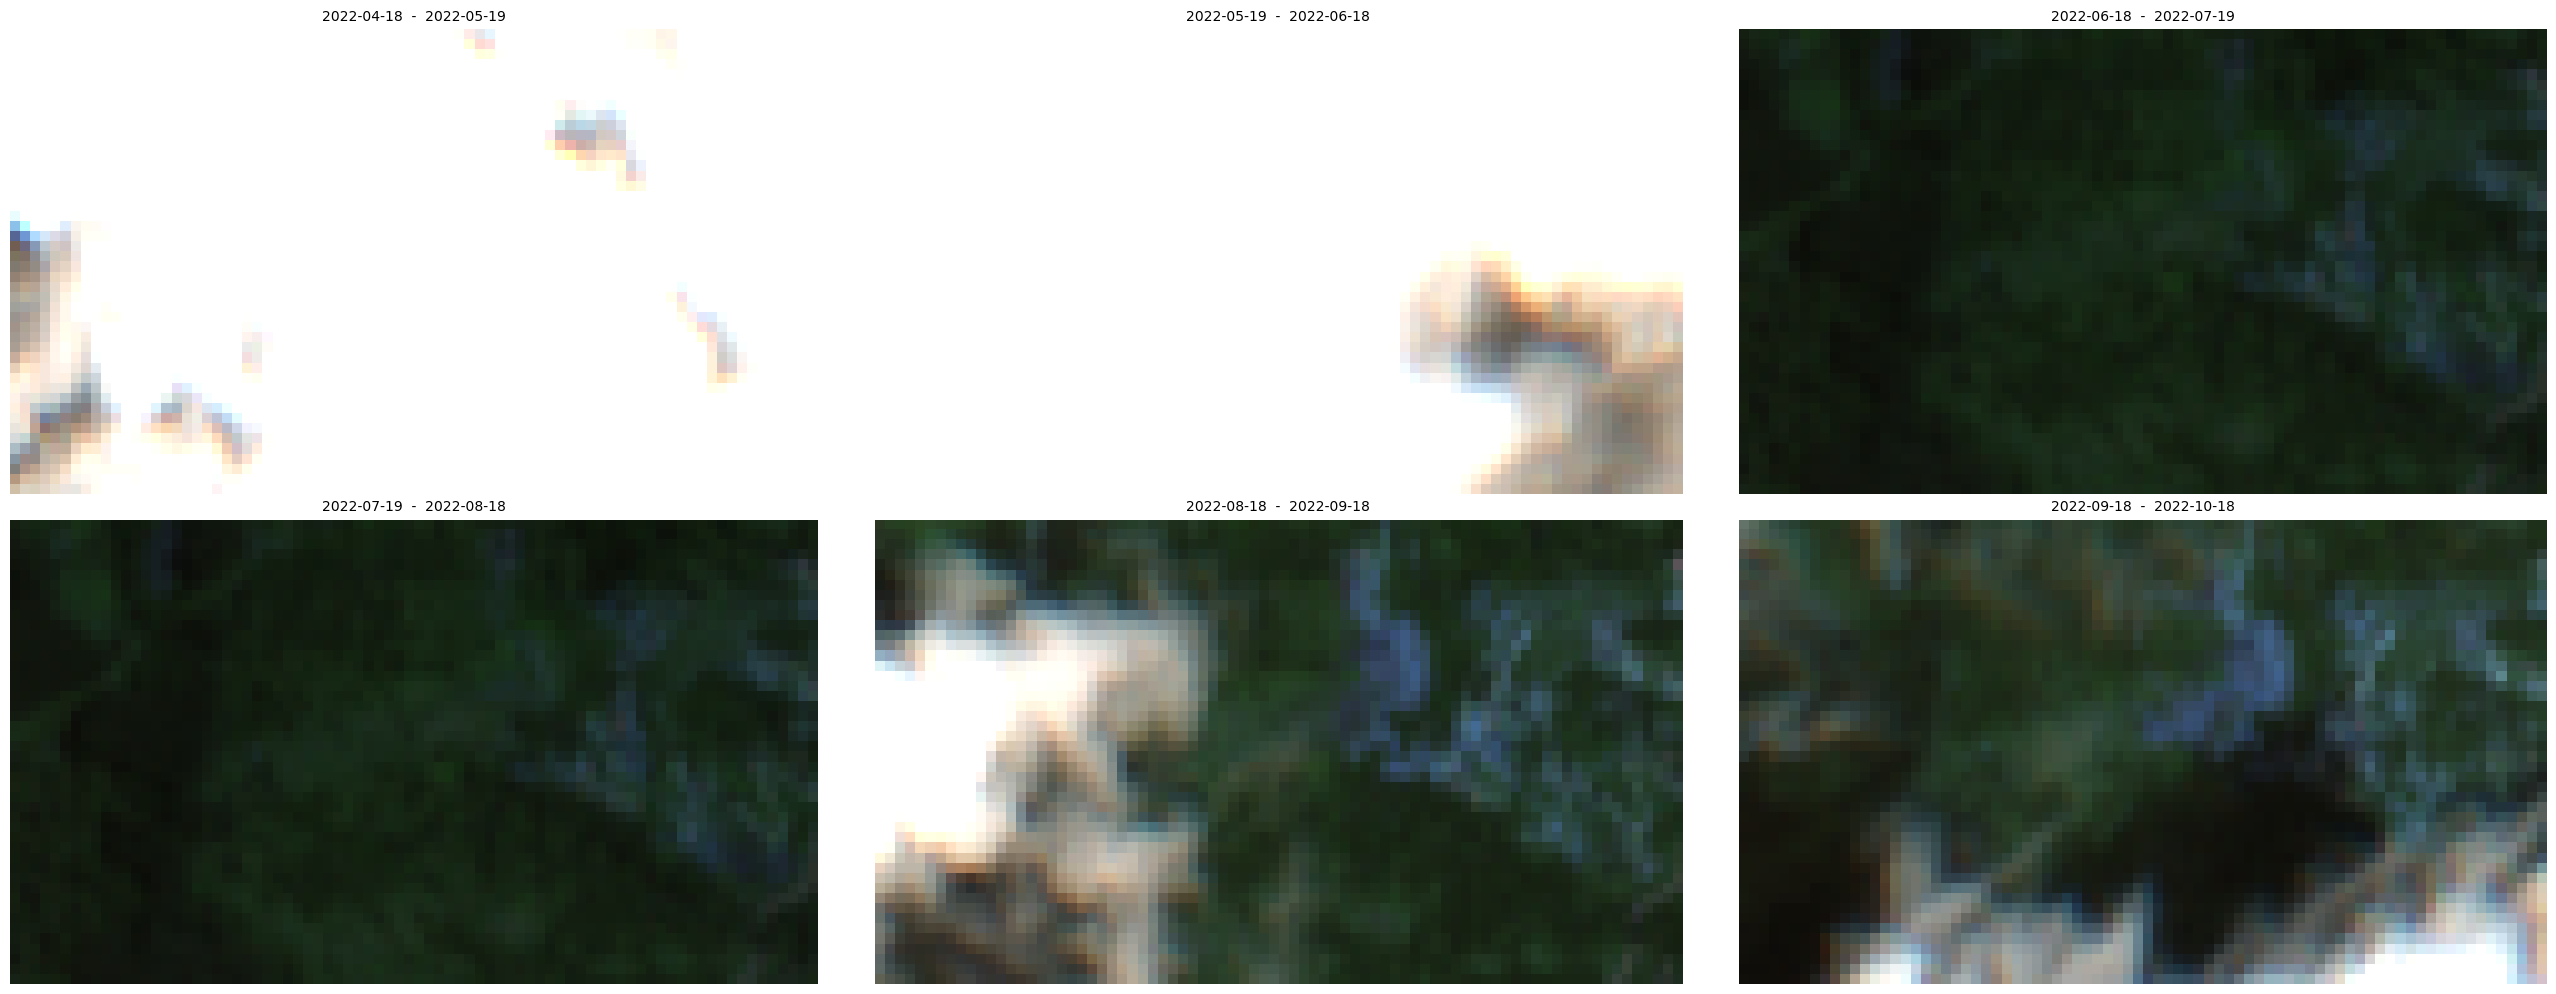

In [14]:
# plotting
cloud_pix=list_of_requests[0][0]
best=np.count_nonzero(cloud_pix == 1) #initializing
ncols = 3
nrows = 2
aspect_ratio = box_size[0] / box_size[1]
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}
pos=0 #position
best_slot=0
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows), subplot_kw=subplot_kw)
cloud_pix=list_of_requests[0][0]
best=np.count_nonzero(cloud_pix == 1)
for  idx, image in enumerate(list_of_requests):
    imagex = image[0][:, :, [0,1, 2]]
    cloud_pix = image[0][:, :, 4]
    cloud = np.count_nonzero(cloud_pix == 1)
    if best >= cloud :
        best=cloud
        best_slot=slots[idx]
        pos = idx
    print(idx,cloud,slots[idx],imagex.shape)
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip(imagex * 2.5 , 0, 1))
    ax.set_title(f"{slots[idx][0]}  -  {slots[idx][1]}", fontsize=10)
plt.tight_layout()
print(best,pos)

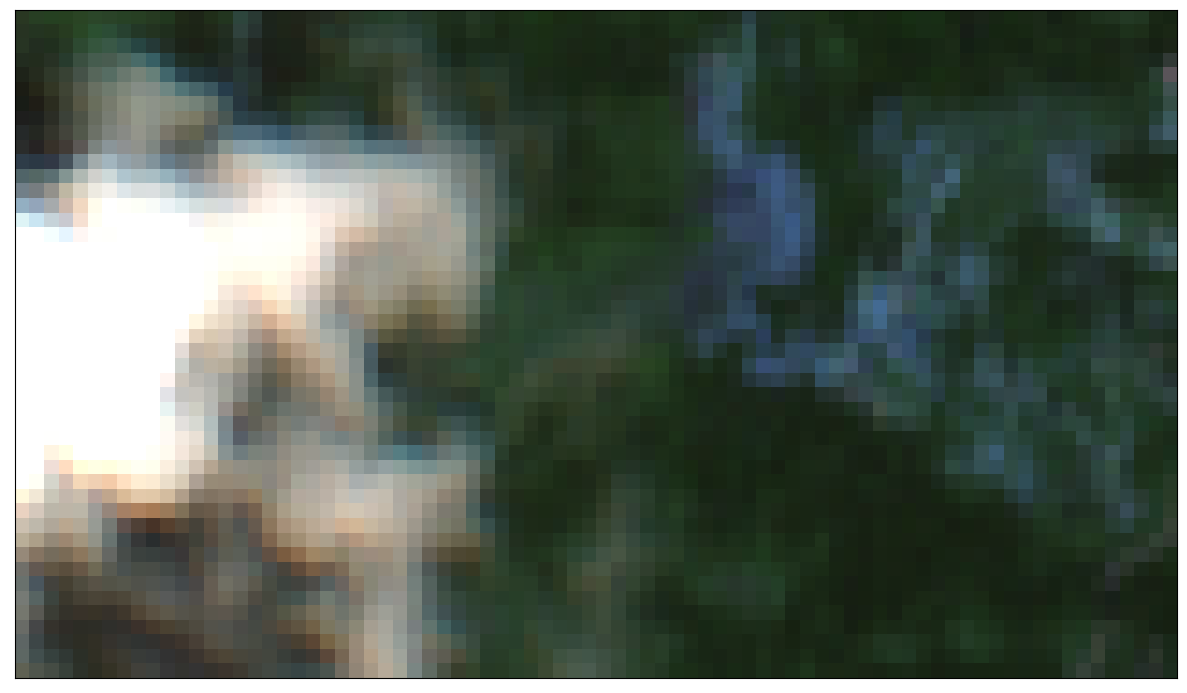

In [15]:
#plot best image
plot_image(list_of_requests[pos][0][:, :, [0, 1, 2]], factor=2.5, clip_range=(0, 1))

In [16]:
import earthpy.spatial as es



In [17]:
list_of_requests[pos][0][:, :, 2].shape

(46, 80)

In [18]:
req = list_of_requests[pos][0][:, :, :]

In [19]:
req[:, :, 3]

array([[0.3388, 0.442 , 0.464 , ..., 0.3364, 0.3372, 0.376 ],
       [0.3012, 0.3892, 0.4116, ..., 0.3384, 0.34  , 0.4036],
       [0.2466, 0.3144, 0.3904, ..., 0.283 , 0.3312, 0.3712],
       ...,
       [0.3192, 0.3172, 0.3288, ..., 0.3452, 0.2556, 0.3616],
       [0.354 , 0.3432, 0.392 , ..., 0.2578, 0.2566, 0.3872],
       [0.3668, 0.3652, 0.3992, ..., 0.261 , 0.303 , 0.4036]],
      dtype=float32)

In [20]:

import earthpy.spatial as es
ndvi = es.normalized_diff(list_of_requests[pos][0][:, :, 3], list_of_requests[pos][0][:, :, 2])

ndvi

array([[0.7940165 , 0.8386023 , 0.84786934, ..., 0.77989423, 0.8461538 ,
        0.88471174],
       [0.79820895, 0.8397542 , 0.851552  , ..., 0.8125335 , 0.8763797 ,
        0.8624827 ],
       [0.76584315, 0.825254  , 0.87062764, ..., 0.8106206 , 0.87330323,
        0.8643897 ],
       ...,
       [0.8450867 , 0.84365016, 0.85500705, ..., 0.78305787, 0.6927152 ,
        0.82626253],
       [0.8209877 , 0.82601756, 0.8622327 , ..., 0.65894467, 0.5800493 ,
        0.8420552 ],
       [0.8113581 , 0.8356371 , 0.85631245, ..., 0.6613622 , 0.7133163 ,
        0.85265094]], dtype=float32)

In [21]:
ndvi.shape

(46, 80)

In [22]:
ndvi[40][50]

0.7056856

In [150]:
all_bands_img = request_all_bands(best_slot).get_data(save_data=True)

In [18]:
pip -V

pip 22.2.2 from C:\Users\Harith\anaconda3\envs\sentinal\lib\site-packages\pip (python 3.8)

Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.
